### <span style="font-family: Century Gothic">Modelling and Testing (Questionnaire ADHD/Sex Classification)</span>

In [119]:
import pandas as pd
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import random
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import shap
import tensorflow as tf

<span style="font-family: Century Gothic; font-size:15px">Load Dataset</span>

In [6]:
df = pd.read_excel('Cleaned_Metadata.xlsx')
df.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,...,PreInt_Demos_Fam_Child_Race_9,PreInt_Demos_Fam_Child_Race_10,PreInt_Demos_Fam_Child_Race_11,MRI_Track_Scan_Location_0,MRI_Track_Scan_Location_1,MRI_Track_Scan_Location_2,MRI_Track_Scan_Location_3,MRI_Track_Scan_Location_4,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,0.825186,-0.059321,-0.567920,0.471031,0.740903,-1.006138,0.671053,0.444049,0.465092,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,-0.883858,1.272741,-0.174889,1,0
1,00fV0OyyoLfw,0.670074,0.300459,-0.567920,-0.316329,-0.700630,1.917403,2.159487,1.203754,1.453973,...,7.192992,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,1,0
2,04X1eiS79T4B,0.557703,0.300459,-0.567920,2.045751,-0.380289,0.056968,1.787378,0.697284,0.465092,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,0,1
3,05ocQutkURd6,0.691545,0.300459,-0.567920,-0.578782,0.420563,-0.740362,0.671053,0.697284,-1.018229,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,0,1
4,06YUNBA9ZRLq,-1.181438,0.300459,3.065452,-0.316329,-0.700630,1.120074,-0.817381,-0.315657,1.948413,...,-0.139024,-0.095663,-0.070505,-0.049793,-0.41607,1.131404,-0.785706,-0.174889,1,0


In [7]:
df.shape

(1213, 54)

<span style="font-family: Century Gothic; font-size:15px">Checking the null values</span>

In [8]:
np.mean(df.isnull().sum())

np.float64(0.0)

<span style="font-family: Century Gothic; font-size:25px">Dataset Summary:</span>

<span style="font-family: Century Gothic; font-size:15px">`1213` samples with `54` features. </span>

<span style="font-family: Century Gothic; font-size:15px"> No missing values, meaning the dataset is fully preprocessed. </span>

<span style="font-family: Century Gothic; font-size:25px"> Target Variables: </span>

<span style="font-family: Century Gothic; font-size:15px"> ADHD_Outcome `0 = No ADHD`, `1 = ADHD`</span>

<span style="font-family: Century Gothic; font-size:15px"> Sex_F `0 = Male`, `1 = Female`</span>

In [10]:
df_model = df.copy()

# <span style="font-family: Century Gothic"> Modelling </span>

In [11]:
# Drop participant ID, extract labels
X = df_model.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).values
y_adhd = df_model['ADHD_Outcome'].values
y_sex = df_model['Sex_F'].values

In [12]:
# Train/Test Split
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X, 
    y_adhd, 
    test_size=0.2, 
    stratify=y_adhd, 
    random_state=42
)

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X, 
    y_sex, 
    test_size=0.2, 
    stratify=y_sex, 
    random_state=42
)

<span style="font-family: Century Gothic; font-size:15px"> BIAS MITIGATION for Simple and Intermediate Models

In [13]:
def calculate_class_weight(y_train: pd.Series):
    return dict(
        enumerate(
            compute_class_weight(
                'balanced',
                classes=np.unique(y_train),
                y = y_train
            )
        )
    )

In [14]:
adhd_class_weight = calculate_class_weight(y_train_adhd)
sex_class_weight = calculate_class_weight(y_train_sex)

In [15]:
adhd_class_weight, sex_class_weight

({0: np.float64(1.5901639344262295), 1: np.float64(0.7293233082706767)},
 {0: np.float64(0.7613814756671899), 1: np.float64(1.4564564564564564)})

In [127]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

<span style="font-family: Century Gothic; font-size:15px"> Model Training Utility

In [30]:
# Train Model

def train_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=cv, 
        scoring='roc_auc', 
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model_ = grid_search.best_estimator_
    
    y_pred = best_model_.predict(X_test)
    y_proba = best_model_.predict_proba(X_test)[:, 1]
    
    print('-----------------------------------------')
    print(f'Best Params: {grid_search.best_params_}')
    print('-----------------------------------------')
    print(classification_report(y_test, y_pred))
    print('-----------------------------------------')
    print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}')
    print('-----------------------------------------')
    
    return best_model_

<span style="font-family: Century Gothic; font-size:15px"> Logistic Regression (Simple)

In [129]:
model_ = LogisticRegression(
    class_weight=adhd_class_weight, 
    solver='liblinear'
)

params_lr = {
    'C': [0.01, 0.1, 1, 10]
}

lr_adhd = train_model(
    model_,
    params_lr, 
    X_train_adhd, 
    y_train_adhd, 
    X_test_adhd, 
    y_test_adhd
)

-----------------------------------------
Best Params: {'C': 0.1}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        77
           1       0.86      0.79      0.82       166

    accuracy                           0.77       243
   macro avg       0.73      0.75      0.74       243
weighted avg       0.78      0.77      0.77       243

-----------------------------------------
ROC AUC Score: 0.8388
-----------------------------------------


In [130]:
model_ = LogisticRegression(
    class_weight=sex_class_weight, 
    solver='liblinear'
)

lr_sex = train_model(
    model_,
    params_lr, 
    X_train_sex, 
    y_train_sex, 
    X_test_sex, 
    y_test_sex
)

-----------------------------------------
Best Params: {'C': 0.01}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.58      0.65       160
           1       0.44      0.63      0.51        83

    accuracy                           0.60       243
   macro avg       0.59      0.60      0.58       243
weighted avg       0.64      0.60      0.61       243

-----------------------------------------
ROC AUC Score: 0.6175
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Random Forest (Intermediate) Model

In [131]:
model_ = RandomForestClassifier(
    class_weight=adhd_class_weight, 
    random_state=42
)

params_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [5, 10, None]
}

rf_adhd = train_model(
    model_,
    params_rf,
    X_train_adhd,
    y_train_adhd,
    X_test_adhd,
    y_test_adhd
)

-----------------------------------------
Best Params: {'max_depth': None, 'n_estimators': 200}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.45      0.56        77
           1       0.79      0.93      0.85       166

    accuracy                           0.78       243
   macro avg       0.77      0.69      0.71       243
weighted avg       0.77      0.78      0.76       243

-----------------------------------------
ROC AUC Score: 0.8215
-----------------------------------------


In [132]:
model_ = RandomForestClassifier(
    class_weight=sex_class_weight, 
    random_state=42
)

rf_sex = train_model(
    model_,
    params_rf,
    X_train_sex,
    y_train_sex,
    X_test_sex,
    y_test_sex
)

-----------------------------------------
Best Params: {'max_depth': 10, 'n_estimators': 200}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.91      0.79       160
           1       0.58      0.25      0.35        83

    accuracy                           0.68       243
   macro avg       0.64      0.58      0.57       243
weighted avg       0.66      0.68      0.64       243

-----------------------------------------
ROC AUC Score: 0.6319
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Complex Model

In [133]:
model_ = MLPClassifier(
    max_iter=700, 
    random_state=42
)

params_mlp = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)], 
    'alpha': [0.0001, 0.001]
}


mlp_adhd = train_model(
    model_,
    params_mlp, 
    X_train_adhd, 
    y_train_adhd, 
    X_test_adhd, 
    y_test_adhd
)

-----------------------------------------
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        77
           1       0.78      0.87      0.82       166

    accuracy                           0.74       243
   macro avg       0.70      0.66      0.67       243
weighted avg       0.73      0.74      0.73       243

-----------------------------------------
ROC AUC Score: 0.7558
-----------------------------------------


In [134]:
model_ = MLPClassifier(
    max_iter=500, 
    random_state=42
)

mlp_sex = train_model(
    model_, 
    params_mlp, 
    X_train_sex, 
    y_train_sex, 
    X_test_sex, 
    y_test_sex
)

-----------------------------------------
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (64, 32)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       160
           1       0.47      0.52      0.49        83

    accuracy                           0.63       243
   macro avg       0.60      0.61      0.60       243
weighted avg       0.64      0.63      0.64       243

-----------------------------------------
ROC AUC Score: 0.6143
-----------------------------------------


<span style="font-family: Century Gothic; font-size:15px"> Complex Model (Deep Keras)

In [37]:
def create_mlp(input_dim, lr=0.001, dropout_rate=0.3):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [39]:
scaler = StandardScaler()
X_train_adhd = scaler.fit_transform(X_train_adhd)
X_test_adhd = scaler.transform(X_test_adhd)
X_train_sex = scaler.fit_transform(X_train_sex)
X_test_sex = scaler.transform(X_test_sex)

In [51]:
# Checkpoint
adhd_ckpt = 'adhd_que_best_model.keras'
sex_ckpt = 'sex_que_best_model.keras'

In [88]:
# Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=adhd_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [55]:
# Train MLP for ADHD Prediction
deep_mlp_adhd = create_mlp(X_train_adhd.shape[1])

deep_mlp_adhd.build()
deep_mlp_adhd.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [93]:
history_adhd = deep_mlp_adhd.fit(
    X_train_adhd,
    y_train_adhd, 
    epochs=40, 
    batch_size=32, 
    validation_data=(X_test_adhd, y_test_adhd), 
    callbacks=callbacks,
    verbose=1,
)

# Evaluate Model
y_pred_adhd = (
    deep_mlp_adhd.predict(X_test_adhd) > 0.8
).astype("int32")

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9660 - loss: 0.1044 - val_accuracy: 0.7654 - val_loss: 0.9809
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9603 - loss: 0.0975 - val_accuracy: 0.7695 - val_loss: 0.9928
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9701 - loss: 0.0753 - val_accuracy: 0.7695 - val_loss: 0.9888
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9760 - loss: 0.0742 - val_accuracy: 0.7695 - val_loss: 1.0299
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9645 - loss: 0.0830 - val_accuracy: 0.7737 - val_loss: 0.9758
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9654 - loss: 0.0833 - val_accuracy: 0.7819 - val_loss: 0.9727
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9633 - loss: 0.1002 - val_accuracy: 0.7819 - val_loss: 0.9996
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9729 - loss: 0.0762 - val_accuracy: 0.7654 - val_loss:

In [94]:
print(
    "\n🔹 ADHD Classification Report:\n", 
    classification_report(y_test_adhd, y_pred_adhd)
)

print(
    "🔹 ADHD ROC AUC Score:", 
    roc_auc_score(
        y_test_adhd, 
        deep_mlp_adhd.predict(X_test_adhd)
    )
)


🔹 ADHD Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.55      0.57        77
           1       0.80      0.83      0.81       166

    accuracy                           0.74       243
   macro avg       0.69      0.69      0.69       243
weighted avg       0.73      0.74      0.73       243

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
🔹 ADHD ROC AUC Score: 0.7631826005319982


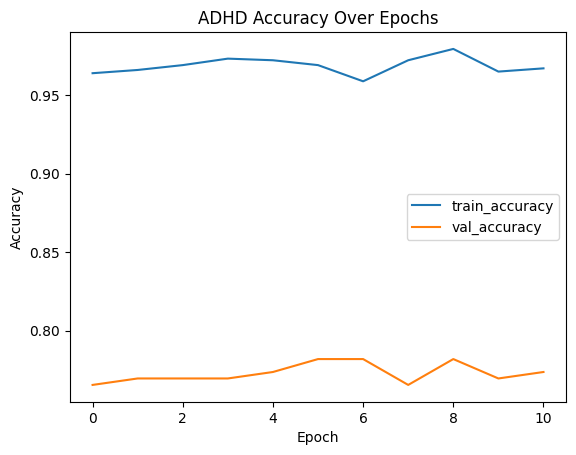

In [95]:
plt.plot(history_adhd.history['accuracy'], label='train_accuracy')
plt.plot(history_adhd.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ADHD Accuracy Over Epochs')
plt.legend()
plt.show()

In [96]:
callbacks[1] = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=sex_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [85]:
# Train MLP for Sex Classification
deep_mlp_sex = create_mlp(X_train_sex.shape[1])

deep_mlp_sex.build()
deep_mlp_sex.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [115]:
history_sex = deep_mlp_sex.fit(
    X_train_sex, 
    y_train_sex, 
    epochs=40, 
    batch_size=32, 
    validation_data=(X_test_sex, y_test_sex), 
    callbacks=callbacks,
    verbose=1
)

# Evaluate Model
y_pred_sex = (
    deep_mlp_sex.predict(X_test_sex) > 0.6
).astype("int32")

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8792 - loss: 0.2885 - val_accuracy: 0.6173 - val_loss: 0.9586
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8598 - loss: 0.3180 - val_accuracy: 0.5967 - val_loss: 0.9702
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8917 - loss: 0.2677 - val_accuracy: 0.5926 - val_loss: 0.9795
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8794 - loss: 0.2711 - val_accuracy: 0.6049 - val_loss: 0.9835
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8444 - loss: 0.3080 - val_accuracy: 0.5844 - val_loss: 0.9946
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8945 - loss: 0.2671 - val_accuracy: 0.6008 - val_loss: 0.9916
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [173]:
print(
    "\n🔹 Sex Classification Report:\n", 
    classification_report(y_test_sex, y_pred_sex)
)

print(
    "🔹 Sex ROC AUC Score:", 
    roc_auc_score(
        y_test_sex, 
        deep_mlp_sex.predict(X_test_sex)
    )
)


🔹 Sex Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       160
           1       0.46      0.37      0.41        83

    accuracy                           0.63       243
   macro avg       0.58      0.57      0.57       243
weighted avg       0.62      0.63      0.62       243

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
🔹 Sex ROC AUC Score: 0.5797439759036145


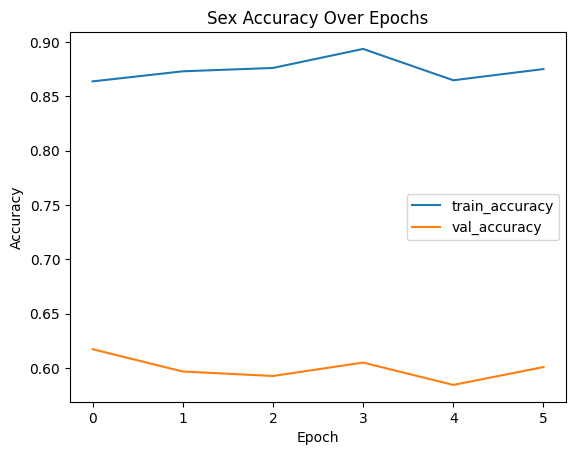

In [117]:
plt.plot(history_sex.history['accuracy'], label='train_accuracy')
plt.plot(history_sex.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Sex Accuracy Over Epochs')
plt.legend()
plt.show()

# <span style="font-family: Century Gothic; font-size:15px"> Very poor performance with Keras, won't continue with it

In [174]:
models = {
    "LR_ADHD": (lr_adhd, X_test_adhd, y_test_adhd),
    "LR_SEX": (lr_sex, X_test_sex, y_test_adhd),
    
    "RF_ADHD": (rf_adhd, X_test_adhd, y_test_adhd),
    "RF_SEX": (rf_sex, X_test_sex, y_test_adhd),
    
    "MLP_ADHD": (mlp_adhd, X_test_adhd, y_test_adhd),
    "MLP_SEX": (mlp_sex, X_test_sex, y_test_sex),
}

In [175]:
results = []
for name, (model, X_test, y_true) in models.items():
    y_pred = model.predict(X_test)
        
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    })

In [167]:
comparison_df = pd.DataFrame(results)

comparison_df.to_csv("que_model_comparison_table.csv", index=False)
comparison_df

,Model,Accuracy,F1 Score,ROC AUC
0,LR_ADHD,0.765432,0.821317,0.751721
1,LR_SEX,0.559671,0.624561,0.573267
2,RF_ADHD,0.777778,0.850829,0.691128
3,RF_SEX,0.399177,0.277228,0.532389
4,MLP_ADHD,0.740741,0.821530,0.664020
5,MLP_SEX,0.633745,0.491429,0.605911


<span style="font-family: Century Gothic"> 🧠 ADHD Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> All models performed reasonably well, with Random Forest `RF_ADHD` having the highest F1 Score `0.85` and Accuracy `0.78`.</span>

<span style="font-family: Century Gothic; font-size: 15px">Logistic Regression `LR_ADHD` also demonstrated strong performance, with a competitive ROC AUC `0.75`, suggesting its robustness.</span>

<span style="font-family: Century Gothic; font-size: 15px">`MLP_ADHD` performed slightly lower in `ROC AUC` but still maintained solid `F1` and `Accuracy` scores. </span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: `Random Forest` and `Logistic Regression` are the most reliable models for `ADHD` classification, with Random Forest having a slight edge in predictive power</span>

<span style="font-family: Century Gothic"> 🧬 Sex Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> Results were more varied and overall less performant compared to `ADHD` classification.</span>

<span style="font-family: Century Gothic; font-size: 15px">`MLP_SEX` achieved the best overall balance, with Accuracy `0.63` and `ROC AUC` 0.61, though `F1` Score was moderate.</span>

<span style="font-family: Century Gothic; font-size: 15px">Logistic Regression `LR_SEX` performed acceptably F1 Score `0.62`, but Random Forest `RF_SEX` performed poorly across all metrics.</span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: `Sex` classification is a more difficult task in this dataset less discriminative features. `MLP` and `Logistic Regression` are preferred; Random Forest should be avoided.</span>

# <span style="font-family: Century Gothic"> SHAP EXPLAINABILITY

In [191]:
X = df_model.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
feature_names = X.columns.tolist()

In [ ]:
def shap_explainer(model, train, test):
    explainer = shap.LinearExplainer(model, train) if isinstance(model, LogisticRegression) else shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test)
    shap.summary_plot(shap_values, test, feature_names)

In [196]:
def shap_neural_network(model, train, test):
    data = shap.sample(train, 100, random_state=42)
    explainer = shap.Explainer(model.predict_proba, data)
    values = explainer.shap_values(test[:10])

    shap.summary_plot(values, test[:10], feature_names)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\476349012.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test, feature_names)


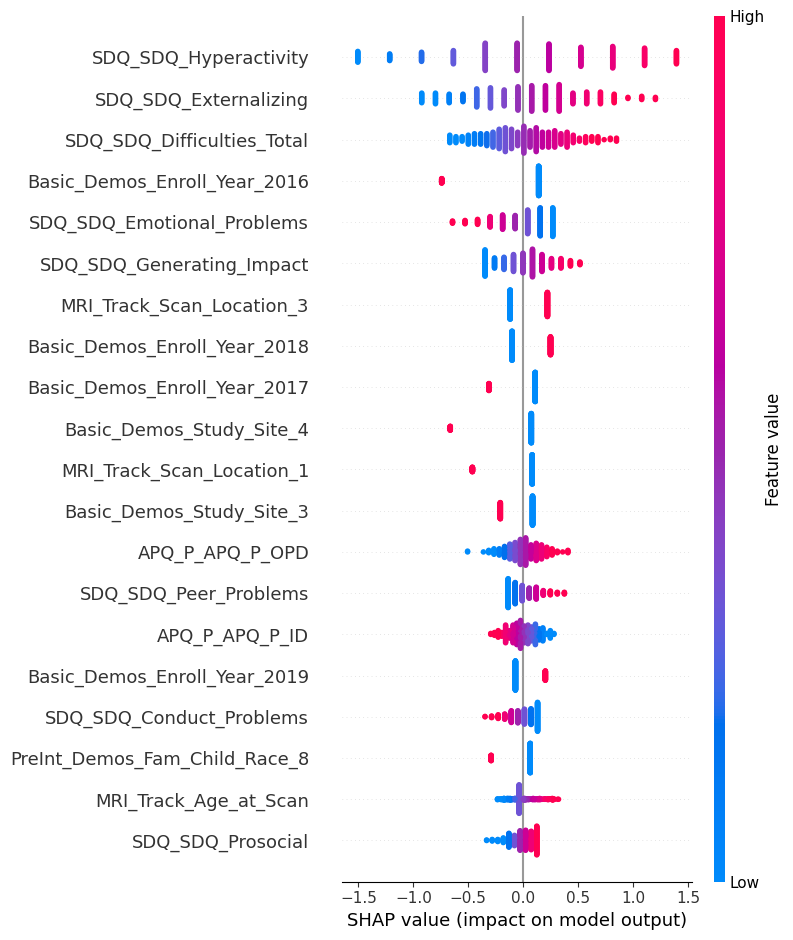

In [195]:
shap_explainer(
    lr_adhd, 
    X_train_adhd, 
    X_test_adhd
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\476349012.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test, feature_names)


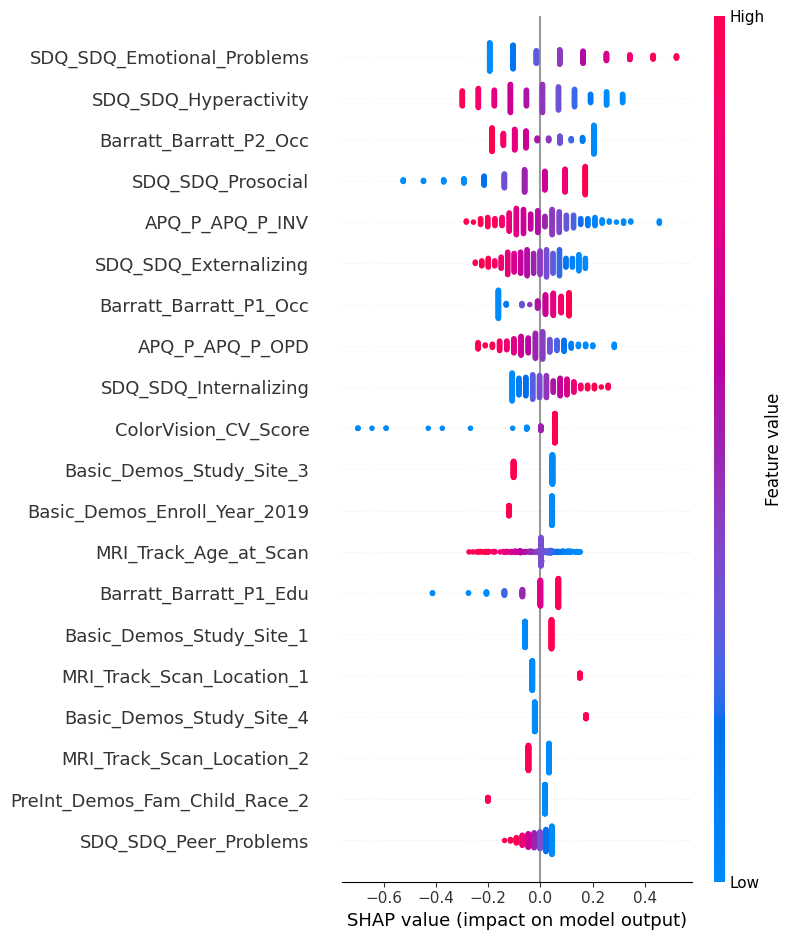

In [197]:
shap_explainer(
    lr_sex, 
    X_train_sex, 
    X_test_sex
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\476349012.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test, feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summar

<Figure size 640x480 with 0 Axes>

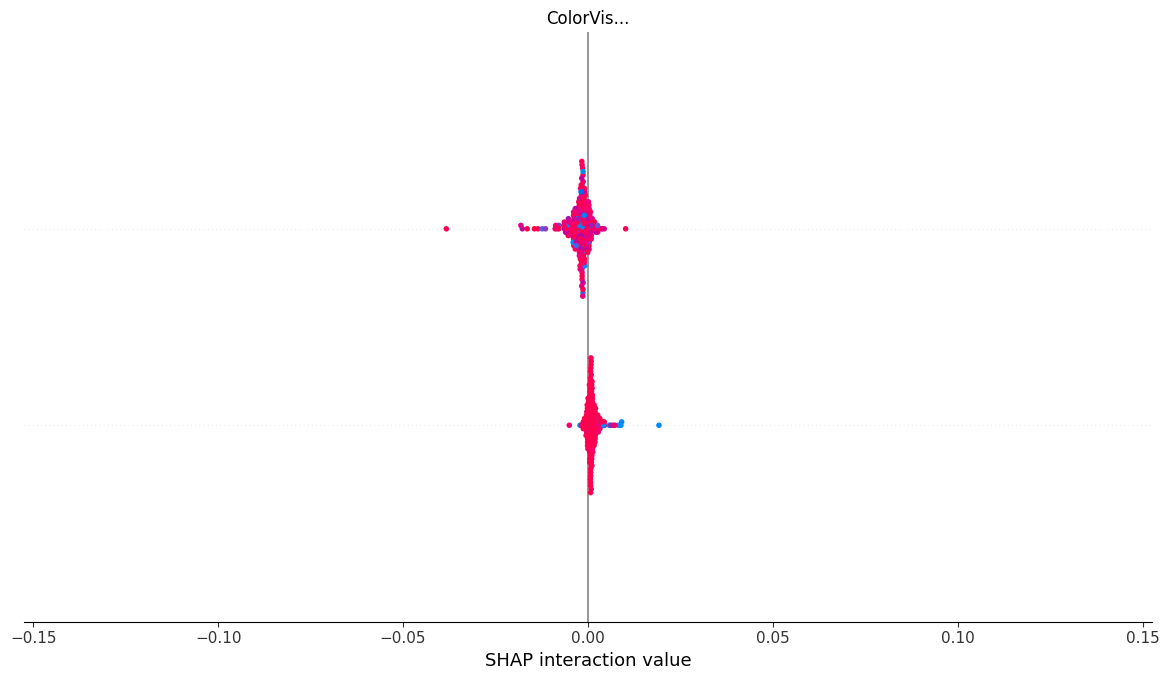

In [198]:
shap_explainer(
    rf_adhd,
    X_train_adhd,
    X_test_adhd
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\476349012.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test, feature_names)
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summar

<Figure size 640x480 with 0 Axes>

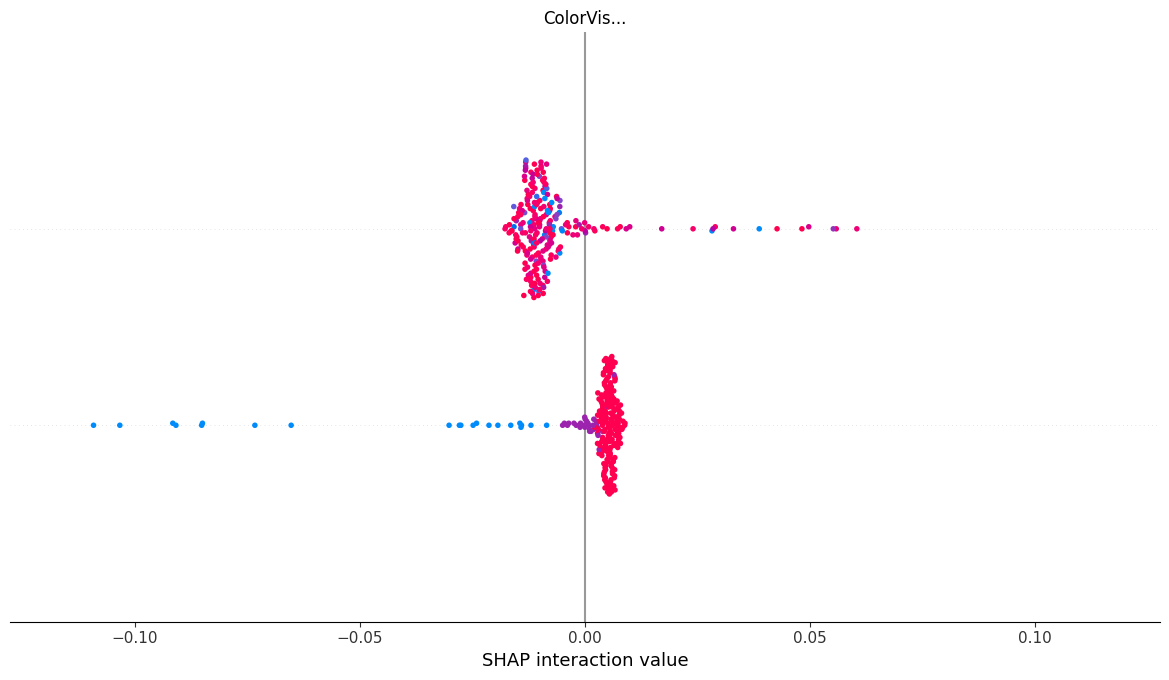

In [199]:
shap_explainer(
    rf_sex,
    X_train_sex,
    X_test_sex
)

PermutationExplainer explainer: 11it [00:12,  1.30s/it]                       
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\2677659935.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test[:10])
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly 

<Figure size 640x480 with 0 Axes>

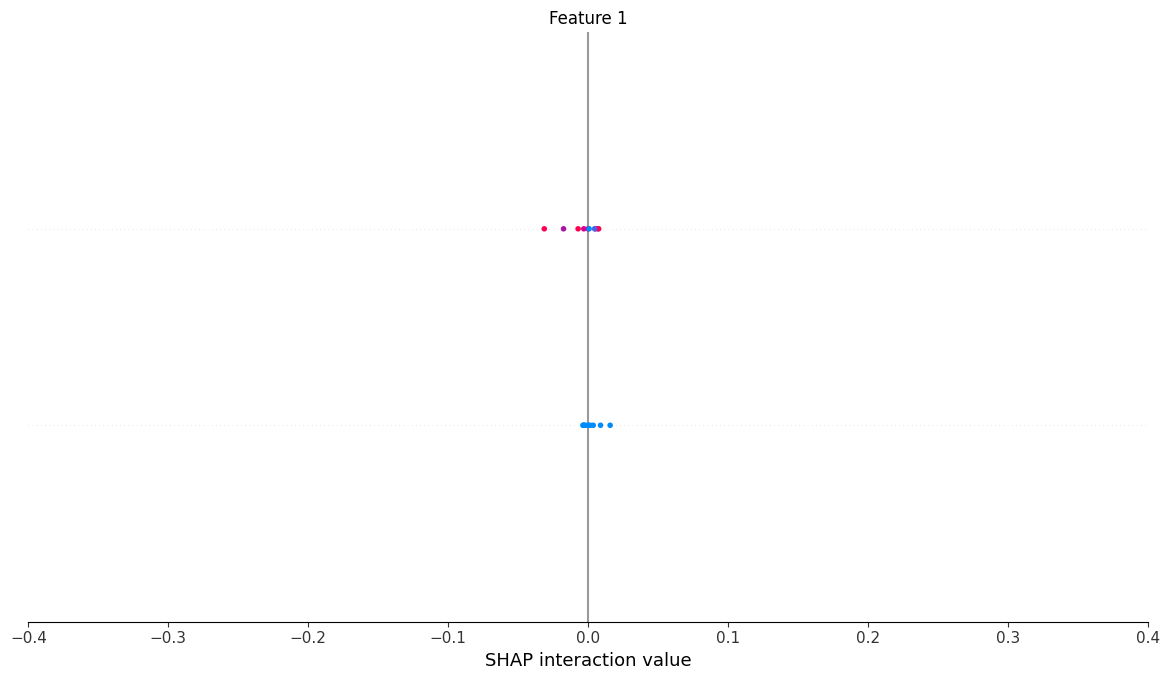

In [140]:
shap_neural_network(
    mlp_adhd,
    X_train_adhd,
    X_test_adhd
)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19972\2677659935.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values, test[:10])
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

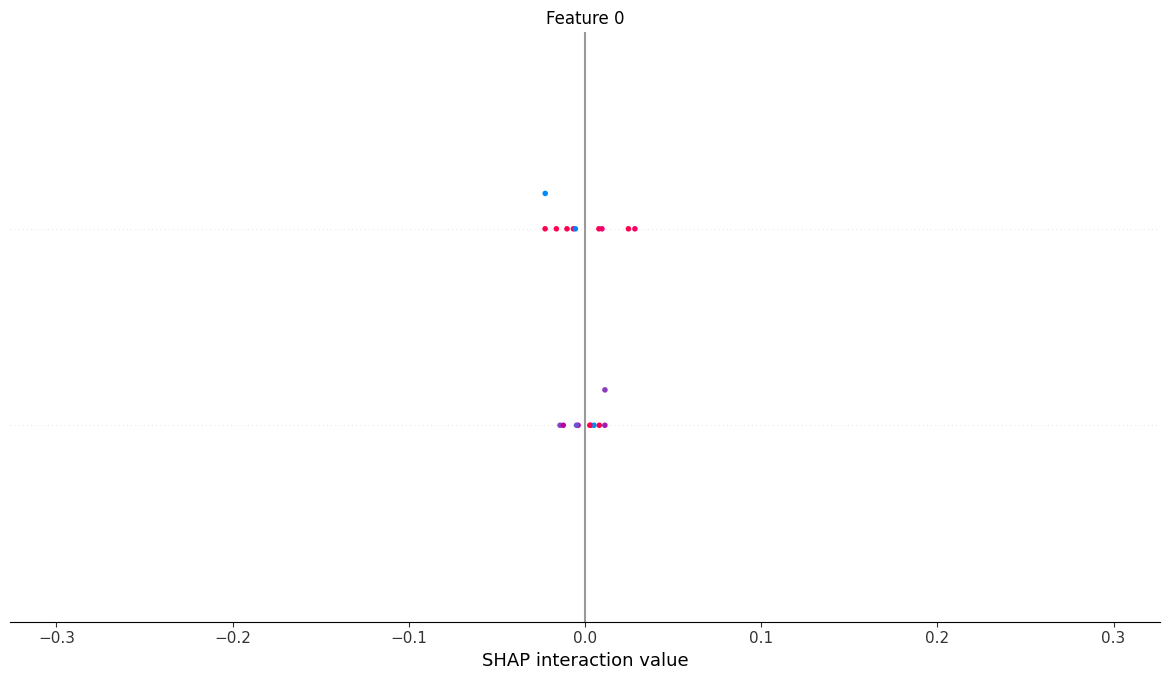

In [147]:
shap_neural_network(
    mlp_sex,
    X_train_sex,
    X_test_sex
)